# Check Dataset

In [3]:
%reset -f
import warnings
from collections import defaultdict

warnings.filterwarnings("ignore")
import os
import numpy as np
import matplotlib.pyplot as plt

from lib import loaders_mimo, modules
from torchsummary import summary
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm import tqdm

import copy
import time
print('import finished!')

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(device)

dir_dataset1 = r'/mnt/mydisk/hgjia/data/UrbanMIMOMap'
Radio_train = loaders_mimo.RadioUNet_c_mimo(phase="train", dir_dataset=dir_dataset1)
Radio_val = loaders_mimo.RadioUNet_c_mimo(phase="val",dir_dataset=dir_dataset1)
Radio_test = loaders_mimo.RadioUNet_c_mimo(phase="test",dir_dataset=dir_dataset1)
print(len(Radio_train), len(Radio_val), len(Radio_test))


batch_size = 64
dataloaders = {
    'train': DataLoader(Radio_train, batch_size = batch_size, shuffle = True, num_workers = 2),
    'val': DataLoader(Radio_val, batch_size = batch_size, shuffle = True, num_workers = 2)
}
print(len(dataloaders['train']), len(dataloaders['val']))

# ==================================================================
# ===== 新增的验证代码从这里开始 =====
# ==================================================================

# 1. 创建一个新的文件夹用于保存测试结果
output_dir = 'dataset_verification_samples'
os.makedirs(output_dir, exist_ok=True)
print(f"保存验证图片的文件夹: '{output_dir}/'")

# 2. 从每个集中取5个例子
datasets_to_check = {
    'train': Radio_train,
    'val': Radio_val,
    'test': Radio_test
}
num_samples_to_check = 5

for phase, dataset in datasets_to_check.items():
    print(f"\n--- 正在处理 {phase} 集 ---")
    for i in range(num_samples_to_check):
        # 从加载器中获取数据
        inputs_tensor, gain_tensor, name = dataset[i]

        # 3. 将Tensor转换为可显示的Numpy数组
        # --- 处理Input Tensor (4通道 -> 3通道RGB) ---
        # 我们将Buildings映射到红色通道，Tx映射到绿色通道
        buildings_channel = inputs_tensor[0].numpy()
        tx_channel = inputs_tensor[1].numpy()
        
        # 创建一个 HxWxC 格式的RGB图像
        input_rgb_np = np.zeros((512, 512, 3), dtype=np.uint8)
        input_rgb_np[:, :, 0] = (buildings_channel * 255).astype(np.uint8) # 红色: 建筑物
        input_rgb_np[:, :, 1] = (tx_channel * 255).astype(np.uint8)      # 绿色: 发射器

        # --- 处理Gain Tensor (1通道 -> 3通道RGB) ---
        gain_np = gain_tensor.squeeze(0).numpy() # 移除通道维度
        gain_rgb_np = (np.stack([gain_np] * 3, axis=-1) * 255).astype(np.uint8)

        # 4. 将Input和Gain拼接并保存
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        fig.suptitle(f'Sample from {phase.upper()} Set - Name: {name}', fontsize=16)

        # 显示输入图像
        ax[0].imshow(input_rgb_np)
        ax[0].set_title('Input (R: Buildings, G: Tx)')
        ax[0].axis('off')
        
        # 在发射器位置添加绿色"×"标记
        tx_positions = np.where(tx_channel > 0)
        if len(tx_positions[0]) > 0:
            for y, x in zip(tx_positions[0], tx_positions[1]):
                # 将像素坐标转换为图像坐标
                ax[0].plot(x, y, 'gx', markersize=8, markeredgewidth=2)

        ax[1].imshow(gain_rgb_np)
        ax[1].set_title('Ground Truth (Gain)')
        ax[1].axis('off')
        
        # 构建文件名并保存
        filename = os.path.join(output_dir, f"{phase}_{name}.png")
        plt.savefig(filename, bbox_inches='tight')
        plt.close(fig) # 关闭图像以释放内存
        
        print(f"已保存: {filename}")

import finished!
cuda:2
30000 6000 6000
469 94
保存验证图片的文件夹: 'dataset_verification_samples/'

--- 正在处理 train 集 ---
已保存: dataset_verification_samples/train_157_0_0.png
已保存: dataset_verification_samples/train_157_0_60.png
已保存: dataset_verification_samples/train_157_0_120.png
已保存: dataset_verification_samples/train_157_1_0.png
已保存: dataset_verification_samples/train_157_1_60.png

--- 正在处理 val 集 ---
已保存: dataset_verification_samples/val_213_0_0.png
已保存: dataset_verification_samples/val_213_0_60.png
已保存: dataset_verification_samples/val_213_0_120.png
已保存: dataset_verification_samples/val_213_1_0.png
已保存: dataset_verification_samples/val_213_1_60.png

--- 正在处理 test 集 ---
已保存: dataset_verification_samples/test_34_0_0.png
已保存: dataset_verification_samples/test_34_0_60.png
已保存: dataset_verification_samples/test_34_0_120.png
已保存: dataset_verification_samples/test_34_1_0.png
已保存: dataset_verification_samples/test_34_1_60.png


## Dataset Loader

In [4]:
batch_size = 64
dataloaders = {
    'train': DataLoader(Radio_train, batch_size = batch_size, shuffle = True, num_workers = 2),
    'val': DataLoader(Radio_val, batch_size = batch_size, shuffle = True, num_workers = 2)
}
print(len(dataloaders['train']), len(dataloaders['val']))


469 94


## Test Sample Image

torch.Size([4, 512, 512]) torch.Size([1, 512, 512]) gain_name:157_0_0


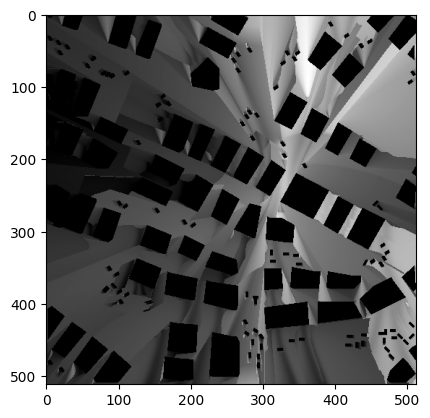

In [5]:
i = 0
image_build_ant, image_gain, gain_name_for_check = Radio_train[i]
print(image_build_ant.shape, image_gain.shape, f"gain_name:{gain_name_for_check}")
plt.imshow(image_gain[0], cmap = "gray")

torch.Size([512, 512])


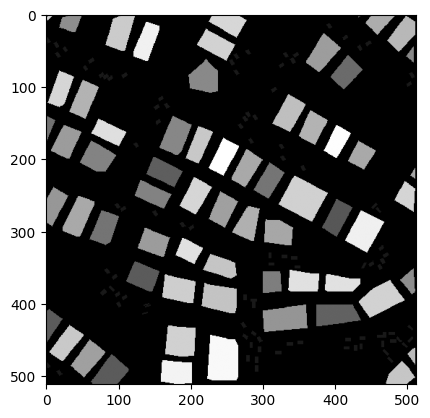

In [6]:
print(image_build_ant[0].shape)
plt.imshow(image_build_ant[0], cmap = "gray")

1
(array([234]), array([330]))
tensor([1.])


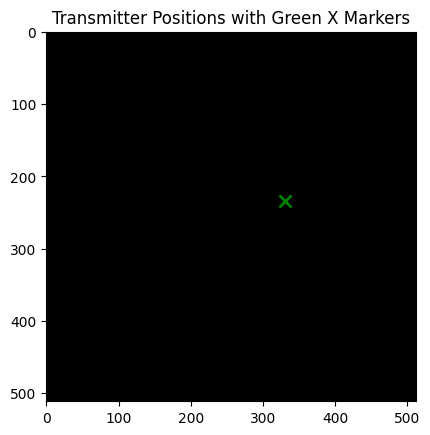

In [8]:
img1 = image_build_ant[1]
plt.imshow(img1, cmap = "gray")

# 打印这个矩阵的非空值，打印坐标，打印值
print(np.count_nonzero(img1))
print(np.where(img1))
print(img1[np.where(img1)])

# 在发射器位置添加绿色"×"标记
tx_positions = np.where(img1 > 0)
if len(tx_positions[0]) > 0:
    for y, x in zip(tx_positions[0], tx_positions[1]):
        plt.plot(x, y, 'gx', markersize=8, markeredgewidth=2)

plt.title('Transmitter Positions with Green X Markers')
plt.show()

## Load Model and Summary

In [8]:
from torchsummary import summary

# torch.set_default_dtype(torch.cuda.FloatTensor)
# torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.backends.cudnn.enabled
model = modules.RadioWNet(phase = "firstU")
# summary(model, input_size = (2, 512, 512))

## Training Loop

In [9]:
#Adapted from https://github.com/usuyama/pytorch-unet


def calc_loss_dense(pred, target, metrics):
    criterion = nn.MSELoss()
    loss = criterion(pred, target)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss


def calc_loss_sparse(pred, target, samples, metrics, num_samples):
    criterion = nn.MSELoss()
    loss = criterion(samples * pred, samples * target) * (256 ** 2) / num_samples
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss


def print_metrics(metrics, epoch_samples, phase):
    outputs1 = []
    outputs2 = []
    for k in metrics.keys():
        outputs1.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs1)))


def train_model(model, optimizer, scheduler, 
                num_epochs = 30, 
                WNetPhase = "firstU", 
                targetType = "dense", 
                num_samples = 200, 
                device = device):
    # WNetPhase: traine first U and freez second ("firstU"), or vice verse ("secondU").
    # targetType: train against dense images ("dense") or sparse measurements ("sparse")
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("learning rate", param_group['lr'])
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            if targetType == "dense":
                for batch_idx, (inputs, targets, gain_name_for_check) in tqdm(enumerate(dataloaders[phase]), total=len(dataloaders[phase]), desc=f'{phase} dense'):
                    inputs = inputs.to(device)
                    targets = targets.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        [outputs1, outputs2] = model(inputs)
                        if WNetPhase == "firstU":
                            loss = calc_loss_dense(outputs1, targets, metrics)
                        else:
                            loss = calc_loss_dense(outputs2, targets, metrics)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    epoch_samples += inputs.size(0)
            elif targetType == "sparse":
                for inputs, targets, samples in dataloaders[phase]:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    samples = samples.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        [outputs1, outputs2] = model(inputs)
                        if WNetPhase == "firstU":
                            loss = calc_loss_sparse(outputs1, targets, samples, metrics, num_samples)
                        else:
                            loss = calc_loss_sparse(outputs2, targets, samples, metrics, num_samples)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Training First UNet


In [10]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.optim import lr_scheduler


model = model.to(device)
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 1e-5)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 8, gamma = 0.1)
model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs = 20,device=device)

Epoch 0/19
----------
learning rate 1e-05


train dense: 100%|██████████| 469/469 [12:09<00:00,  1.56s/it]

train: loss: 0.084192



val dense: 100%|██████████| 94/94 [01:27<00:00,  1.08it/s]

val: loss: 0.039359
saving best model
13m 37s
Epoch 1/19
----------
learning rate 1e-05



train dense: 100%|██████████| 469/469 [12:09<00:00,  1.56s/it]

train: loss: 0.036453



val dense: 100%|██████████| 94/94 [01:27<00:00,  1.08it/s]

val: loss: 0.034746
saving best model
13m 37s
Epoch 2/19
----------
learning rate 1e-05



train dense: 100%|██████████| 469/469 [12:10<00:00,  1.56s/it]

train: loss: 0.033718



val dense: 100%|██████████| 94/94 [01:27<00:00,  1.08it/s]

val: loss: 0.032855
saving best model
13m 38s
Epoch 3/19
----------
learning rate 1e-05



train dense: 100%|██████████| 469/469 [12:10<00:00,  1.56s/it]

train: loss: 0.032608



val dense: 100%|██████████| 94/94 [01:27<00:00,  1.07it/s]


val: loss: 0.032009
saving best model
13m 38s
Epoch 4/19
----------
learning rate 1e-05


train dense: 100%|██████████| 469/469 [12:10<00:00,  1.56s/it]

train: loss: 0.031936



val dense: 100%|██████████| 94/94 [01:27<00:00,  1.08it/s]

val: loss: 0.031496
saving best model
13m 38s
Epoch 5/19
----------
learning rate 1e-05



train dense: 100%|██████████| 469/469 [12:10<00:00,  1.56s/it]

train: loss: 0.031439



val dense: 100%|██████████| 94/94 [01:28<00:00,  1.07it/s]


val: loss: 0.031028
saving best model
13m 39s
Epoch 6/19
----------
learning rate 1e-05


train dense: 100%|██████████| 469/469 [12:09<00:00,  1.56s/it]

train: loss: 0.031031



val dense: 100%|██████████| 94/94 [01:27<00:00,  1.07it/s]


val: loss: 0.030699
saving best model
13m 38s
Epoch 7/19
----------
learning rate 1.0000000000000002e-06


train dense: 100%|██████████| 469/469 [12:10<00:00,  1.56s/it]

train: loss: 0.030740



val dense: 100%|██████████| 94/94 [01:27<00:00,  1.07it/s]

val: loss: 0.030618
saving best model
13m 38s
Epoch 8/19
----------
learning rate 1.0000000000000002e-06



train dense: 100%|██████████| 469/469 [12:10<00:00,  1.56s/it]

train: loss: 0.030710



val dense: 100%|██████████| 94/94 [01:28<00:00,  1.07it/s]


val: loss: 0.030587
saving best model
13m 39s
Epoch 9/19
----------
learning rate 1.0000000000000002e-06


train dense: 100%|██████████| 469/469 [12:10<00:00,  1.56s/it]

train: loss: 0.030673



val dense: 100%|██████████| 94/94 [01:27<00:00,  1.08it/s]


val: loss: 0.030564
saving best model
13m 39s
Epoch 10/19
----------
learning rate 1.0000000000000002e-06


train dense: 100%|██████████| 469/469 [12:10<00:00,  1.56s/it]

train: loss: 0.030637



val dense: 100%|██████████| 94/94 [01:27<00:00,  1.07it/s]

val: loss: 0.030535
saving best model
13m 39s
Epoch 11/19
----------
learning rate 1.0000000000000002e-06



train dense: 100%|██████████| 469/469 [12:11<00:00,  1.56s/it]

train: loss: 0.030597



val dense: 100%|██████████| 94/94 [01:28<00:00,  1.07it/s]

val: loss: 0.030512
saving best model
13m 39s
Epoch 12/19
----------
learning rate 1.0000000000000002e-06



train dense: 100%|██████████| 469/469 [12:11<00:00,  1.56s/it]

train: loss: 0.030566



val dense: 100%|██████████| 94/94 [01:27<00:00,  1.07it/s]


val: loss: 0.030453
saving best model
13m 39s
Epoch 13/19
----------
learning rate 1.0000000000000002e-06


train dense: 100%|██████████| 469/469 [12:12<00:00,  1.56s/it]

train: loss: 0.030528



val dense: 100%|██████████| 94/94 [01:27<00:00,  1.07it/s]


val: loss: 0.030427
saving best model
13m 40s
Epoch 14/19
----------
learning rate 1.0000000000000002e-06


train dense: 100%|██████████| 469/469 [12:12<00:00,  1.56s/it]

train: loss: 0.030489



val dense: 100%|██████████| 94/94 [01:27<00:00,  1.07it/s]


val: loss: 0.030383
saving best model
13m 40s
Epoch 15/19
----------
learning rate 1.0000000000000002e-07


train dense: 100%|██████████| 469/469 [12:11<00:00,  1.56s/it]

train: loss: 0.030457



val dense: 100%|██████████| 94/94 [01:27<00:00,  1.07it/s]

val: loss: 0.030374
saving best model
13m 40s
Epoch 16/19
----------
learning rate 1.0000000000000002e-07



train dense: 100%|██████████| 469/469 [12:12<00:00,  1.56s/it]

train: loss: 0.030453



val dense: 100%|██████████| 94/94 [01:27<00:00,  1.08it/s]

val: loss: 0.030370
saving best model
13m 41s
Epoch 17/19
----------
learning rate 1.0000000000000002e-07



train dense: 100%|██████████| 469/469 [12:11<00:00,  1.56s/it]

train: loss: 0.030448



val dense: 100%|██████████| 94/94 [01:27<00:00,  1.08it/s]

val: loss: 0.030368
saving best model
13m 39s
Epoch 18/19
----------
learning rate 1.0000000000000002e-07



train dense: 100%|██████████| 469/469 [12:11<00:00,  1.56s/it]

train: loss: 0.030445



val dense: 100%|██████████| 94/94 [01:28<00:00,  1.06it/s]


val: loss: 0.030362
saving best model
13m 41s
Epoch 19/19
----------
learning rate 1.0000000000000002e-07


train dense: 100%|██████████| 469/469 [12:13<00:00,  1.56s/it]

train: loss: 0.030441



val dense: 100%|██████████| 94/94 [01:27<00:00,  1.07it/s]


val: loss: 0.030360
saving best model
13m 42s
Best val loss: 0.030360


## Create Directory For Saving the Model and Examples

In [11]:
import os

try:
    os.makedirs('RadioWNet_c_MIMO', exist_ok=True)
except OSError as error:
    print(error)

## Save First U Model For Inference

In [12]:
torch.save(model.state_dict(), 'RadioWNet_c_MIMO/Trained_Model_FirstU.pt')

## Second U Module

In [13]:
model = modules.RadioWNet(phase = "secondU")
model.load_state_dict(torch.load('RadioWNet_c_MIMO/Trained_Model_FirstU.pt'))

<All keys matched successfully>

## Training Scond UNet

In [14]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler

model = model.to(device)
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 2e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 12, gamma = 0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler,num_epochs=30, WNetPhase = "secondU",device = device)

Epoch 0/29
----------
learning rate 0.0002


train dense: 100%|██████████| 469/469 [12:02<00:00,  1.54s/it]

train: loss: 0.034305



val dense: 100%|██████████| 94/94 [01:27<00:00,  1.07it/s]


val: loss: 0.029363
saving best model
13m 31s
Epoch 1/29
----------
learning rate 0.0002


train dense: 100%|██████████| 469/469 [12:03<00:00,  1.54s/it]

train: loss: 0.028836



val dense: 100%|██████████| 94/94 [01:29<00:00,  1.05it/s]


val: loss: 0.027949
saving best model
13m 33s
Epoch 2/29
----------
learning rate 0.0002


train dense: 100%|██████████| 469/469 [12:04<00:00,  1.54s/it]

train: loss: 0.027883



val dense: 100%|██████████| 94/94 [01:28<00:00,  1.06it/s]


val: loss: 0.027452
saving best model
13m 33s
Epoch 3/29
----------
learning rate 0.0002


train dense: 100%|██████████| 469/469 [12:04<00:00,  1.55s/it]

train: loss: 0.023646



val dense: 100%|██████████| 94/94 [01:27<00:00,  1.07it/s]


val: loss: 0.019676
saving best model
13m 33s
Epoch 4/29
----------
learning rate 0.0002


train dense: 100%|██████████| 469/469 [12:04<00:00,  1.54s/it]

train: loss: 0.018935



val dense: 100%|██████████| 94/94 [01:28<00:00,  1.06it/s]


val: loss: 0.017937
saving best model
13m 33s
Epoch 5/29
----------
learning rate 0.0002


train dense: 100%|██████████| 469/469 [12:21<00:00,  1.58s/it]

train: loss: 0.017664



val dense: 100%|██████████| 94/94 [01:37<00:00,  1.03s/it]


val: loss: 0.017119
saving best model
13m 59s
Epoch 6/29
----------
learning rate 0.0002


train dense: 100%|██████████| 469/469 [12:32<00:00,  1.61s/it]


train: loss: 0.016858


val dense: 100%|██████████| 94/94 [01:35<00:00,  1.01s/it]


val: loss: 0.016603
saving best model
14m 9s
Epoch 7/29
----------
learning rate 0.0002


train dense: 100%|██████████| 469/469 [12:13<00:00,  1.56s/it]


train: loss: 0.016331


val dense: 100%|██████████| 94/94 [02:00<00:00,  1.28s/it]


val: loss: 0.016231
saving best model
14m 14s
Epoch 8/29
----------
learning rate 0.0002


train dense: 100%|██████████| 469/469 [12:03<00:00,  1.54s/it]

train: loss: 0.016085



val dense: 100%|██████████| 94/94 [01:25<00:00,  1.10it/s]


val: loss: 0.016060
saving best model
13m 30s
Epoch 9/29
----------
learning rate 0.0002


train dense: 100%|██████████| 469/469 [11:55<00:00,  1.53s/it]

train: loss: 0.015747



val dense: 100%|██████████| 94/94 [01:27<00:00,  1.08it/s]


val: loss: 0.015835
saving best model
13m 23s
Epoch 10/29
----------
learning rate 0.0002


train dense: 100%|██████████| 469/469 [11:56<00:00,  1.53s/it]

train: loss: 0.015500



val dense: 100%|██████████| 94/94 [01:26<00:00,  1.08it/s]

val: loss: 0.015828
saving best model
13m 24s
Epoch 11/29
----------
learning rate 2e-05



train dense: 100%|██████████| 469/469 [11:57<00:00,  1.53s/it]

train: loss: 0.014994



val dense: 100%|██████████| 94/94 [01:29<00:00,  1.05it/s]


val: loss: 0.015343
saving best model
13m 28s
Epoch 12/29
----------
learning rate 2e-05


train dense: 100%|██████████| 469/469 [12:04<00:00,  1.54s/it]

train: loss: 0.014928



val dense: 100%|██████████| 94/94 [01:27<00:00,  1.07it/s]


val: loss: 0.015319
saving best model
13m 33s
Epoch 13/29
----------
learning rate 2e-05


train dense: 100%|██████████| 469/469 [11:57<00:00,  1.53s/it]


train: loss: 0.014885


val dense: 100%|██████████| 94/94 [01:26<00:00,  1.08it/s]


val: loss: 0.015309
saving best model
13m 25s
Epoch 14/29
----------
learning rate 2e-05


train dense: 100%|██████████| 469/469 [11:58<00:00,  1.53s/it]

train: loss: 0.014861



val dense: 100%|██████████| 94/94 [01:27<00:00,  1.08it/s]


val: loss: 0.015278
saving best model
13m 26s
Epoch 15/29
----------
learning rate 2e-05


train dense: 100%|██████████| 469/469 [11:56<00:00,  1.53s/it]

train: loss: 0.014823



val dense: 100%|██████████| 94/94 [01:29<00:00,  1.05it/s]


val: loss: 0.015281
13m 27s
Epoch 16/29
----------
learning rate 2e-05


train dense: 100%|██████████| 469/469 [12:03<00:00,  1.54s/it]

train: loss: 0.014789



val dense: 100%|██████████| 94/94 [01:26<00:00,  1.09it/s]


val: loss: 0.015264
saving best model
13m 31s
Epoch 17/29
----------
learning rate 2e-05


train dense: 100%|██████████| 469/469 [11:56<00:00,  1.53s/it]


train: loss: 0.014756


val dense: 100%|██████████| 94/94 [01:26<00:00,  1.09it/s]


val: loss: 0.015213
saving best model
13m 23s
Epoch 18/29
----------
learning rate 2e-05


train dense: 100%|██████████| 469/469 [11:56<00:00,  1.53s/it]

train: loss: 0.014730



val dense: 100%|██████████| 94/94 [01:26<00:00,  1.09it/s]

val: loss: 0.015232
13m 23s
Epoch 19/29
----------
learning rate 2e-05



train dense: 100%|██████████| 469/469 [11:59<00:00,  1.53s/it]

train: loss: 0.014700



val dense: 100%|██████████| 94/94 [01:25<00:00,  1.10it/s]


val: loss: 0.015207
saving best model
13m 26s
Epoch 20/29
----------
learning rate 2e-05


train dense: 100%|██████████| 469/469 [11:55<00:00,  1.53s/it]

train: loss: 0.014666



val dense: 100%|██████████| 94/94 [01:25<00:00,  1.10it/s]

val: loss: 0.015195
saving best model
13m 21s
Epoch 21/29
----------
learning rate 2e-05



train dense: 100%|██████████| 469/469 [11:56<00:00,  1.53s/it]

train: loss: 0.014637



val dense: 100%|██████████| 94/94 [01:26<00:00,  1.09it/s]


val: loss: 0.015218
13m 23s
Epoch 22/29
----------
learning rate 2e-05


train dense: 100%|██████████| 469/469 [11:55<00:00,  1.53s/it]

train: loss: 0.014613



val dense: 100%|██████████| 94/94 [01:26<00:00,  1.09it/s]


val: loss: 0.015126
saving best model
13m 22s
Epoch 23/29
----------
learning rate 2.0000000000000003e-06


train dense: 100%|██████████| 469/469 [11:55<00:00,  1.53s/it]

train: loss: 0.014531



val dense: 100%|██████████| 94/94 [01:26<00:00,  1.09it/s]


val: loss: 0.015102
saving best model
13m 23s
Epoch 24/29
----------
learning rate 2.0000000000000003e-06


train dense: 100%|██████████| 469/469 [11:56<00:00,  1.53s/it]


train: loss: 0.014525


val dense: 100%|██████████| 94/94 [01:26<00:00,  1.08it/s]


val: loss: 0.015090
saving best model
13m 24s
Epoch 25/29
----------
learning rate 2.0000000000000003e-06


train dense: 100%|██████████| 469/469 [11:54<00:00,  1.52s/it]

train: loss: 0.014521



val dense: 100%|██████████| 94/94 [01:25<00:00,  1.10it/s]

val: loss: 0.015090
13m 21s
Epoch 26/29
----------
learning rate 2.0000000000000003e-06



train dense: 100%|██████████| 469/469 [11:56<00:00,  1.53s/it]

train: loss: 0.014516



val dense: 100%|██████████| 94/94 [01:25<00:00,  1.10it/s]

val: loss: 0.015089
saving best model
13m 22s
Epoch 27/29
----------
learning rate 2.0000000000000003e-06



train dense: 100%|██████████| 469/469 [11:55<00:00,  1.53s/it]

train: loss: 0.014514



val dense: 100%|██████████| 94/94 [01:25<00:00,  1.09it/s]


val: loss: 0.015092
13m 22s
Epoch 28/29
----------
learning rate 2.0000000000000003e-06


train dense: 100%|██████████| 469/469 [11:55<00:00,  1.52s/it]

train: loss: 0.014512



val dense: 100%|██████████| 94/94 [01:26<00:00,  1.09it/s]


val: loss: 0.015084
saving best model
13m 22s
Epoch 29/29
----------
learning rate 2.0000000000000003e-06


train dense: 100%|██████████| 469/469 [11:54<00:00,  1.52s/it]

train: loss: 0.014507



val dense: 100%|██████████| 94/94 [01:27<00:00,  1.07it/s]


val: loss: 0.015092
13m 22s
Best val loss: 0.015084


## Save Second U Model For Inference

In [15]:
torch.save(model.state_dict(), 'RadioWNet_c_MIMO/Trained_Model_SecondU.pt')

## Load Second U Model For Inference

In [16]:
model = modules.RadioWNet(phase = "secondU")
model.load_state_dict(torch.load('RadioWNet_c_MIMO/Trained_Model_SecondU.pt'))
model.to(device)

RadioWNet(
  (layer00): Sequential(
    (0): Conv2d(4, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer0): Sequential(
    (0): Conv2d(10, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Conv2d(40, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer10): Sequential(
    (0): Conv2d(50, 60, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(60, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)


## Test Accuracy

In [17]:

from collections import defaultdict
import torch.nn as nn
import torchmetrics

def test_loss_full(model, error="MSE", dataset="coarse", data_range=1.0):
    """
    Tests the model and calculates a specific metric (MSE, NMSE, RMSE, SSIM, PSNR).

    Args:
        model: The PyTorch model to test.
        error (str): The metric to calculate ("MSE", "NMSE", "RMSE", "SSIM", "PSNR").
        dataset (str): Specifies the dataset loader ("coarse" or "fine").
        data_range (float): The maximum possible value in the target/output tensors.
                            Required for SSIM and PSNR calculation.
                            例如，如果你的像素值在 0-1 之间，设置为 1.0；如果在 0-255 之间，设置为 255.0。
    """
    since = time.time()
    model.eval()  # Set model to evaluate mode

    # Initialize torchmetrics objects based on the requested error
    # We need separate instances for pred1 and pred2
    metric1 = None
    metric2 = None
    mse_target_metric = None # Needed specifically for NMSE denominator (MSE(target, 0))

    if error == "MSE":
        metric1 = torchmetrics.regression.MeanSquaredError().to(device)
        metric2 = torchmetrics.regression.MeanSquaredError().to(device)
        metric_name = "MSE"
    elif error == "RMSE":
        # RMSE is the square root of MSE
        metric1 = torchmetrics.regression.MeanSquaredError(squared=False).to(device)
        metric2 = torchmetrics.regression.MeanSquaredError(squared=False).to(device)
        metric_name = "RMSE"
    elif error == "NMSE":
        # NMSE = MSE(pred, target) / MSE(target, 0)
        # We need MSE for both pred1/pred2 vs target, and MSE for target vs 0
        metric1 = torchmetrics.regression.MeanSquaredError().to(device) # This will calculate MSE(pred1, target)
        metric2 = torchmetrics.regression.MeanSquaredError().to(device) # This will calculate MSE(pred2, target)
        mse_target_metric = torchmetrics.regression.MeanSquaredError().to(device) # This will calculate MSE(target, 0)
        metric_name = "NMSE"
    elif error == "SSIM":
        # SSIM requires image-like data (N, C, H, W) or (N, H, W)
        # Make sure your tensors have the correct shape for SSIM
        metric1 = torchmetrics.image.StructuralSimilarityIndexMeasure(data_range=data_range).to(device)
        metric2 = torchmetrics.image.StructuralSimilarityIndexMeasure(data_range=data_range).to(device)
        metric_name = "SSIM"
    elif error == "PSNR":
        # PSNR requires image-like data (N, C, H, W) or (N, H, W)
        # Make sure your tensors have the correct shape for PSNR
        metric1 = torchmetrics.image.PeakSignalNoiseRatio(data_range=data_range).to(device)
        metric2 = torchmetrics.image.PeakSignalNoiseRatio(data_range=data_range).to(device)
        metric_name = "PSNR"
    else:
        raise ValueError(f"Unknown error type: {error}. Supported types: MSE, RMSE, NMSE, SSIM, PSNR")

    epoch_samples = 0 # Keep track of total samples processed

    # Select DataLoader based on dataset type
    if dataset == "coarse":
        # Assuming Radio_test is your coarse dataset class/instance
        dl_test = DataLoader(Radio_test, batch_size=batch_size, shuffle=False, num_workers=1) # Use shuffle=False for consistent evaluation
    elif dataset == "fine":
        # Assuming Radio_test is also used for fine dataset, but might yield different data (e.g., samples_info)
        # If your fine dataset class is different, replace Radio_test with it here
        dl_test = DataLoader(Radio_test, batch_size=batch_size, shuffle=False, num_workers=1)
    else:
         raise ValueError(f"Unknown dataset type: {dataset}")


    # Loop through data
    desc = f"Testing ({dataset.capitalize()} - {error})"
    for batch_idx, batch_data in tqdm(enumerate(dl_test), total=len(dl_test), desc=desc):
        # Handle different dataset outputs based on your DataLoader's __getitem__
        if dataset == "coarse":
             inputs, targets, gain_name_for_check = batch_data
        elif dataset == "fine":
             # Assuming your fine dataset yields inputs, targets, and samples_info
             # Adjust this line if your fine dataset yields something else
             inputs, targets, samples_info = batch_data

        inputs = inputs.to(device)
        targets = targets.to(device)

        # Ensure targets and outputs are float tensors for metrics
        # torchmetrics typically expects float tensors
        targets = targets.float()
        # Note: Model outputs should ideally already be float

        with torch.no_grad(): # Use torch.no_grad() for evaluation
            [outputs1, outputs2] = model(inputs)

            # Ensure outputs match target dtype for metrics
            outputs1 = outputs1.float()
            outputs2 = outputs2.float()

            # Update the relevant metrics with the current batch
            # torchmetrics accumulates the necessary statistics internally
            if metric1 is not None:
                metric1.update(outputs1, targets)
            if metric2 is not None:
                metric2.update(outputs2, targets)
            if mse_target_metric is not None:
                # Update the metric for the NMSE denominator: MSE(target, 0)
                mse_target_metric.update(targets, torch.zeros_like(targets))

        epoch_samples += inputs.size(0)

    # Compute the final metric values after the loop
    metrics = defaultdict(float)

    if error == "NMSE":
        # For NMSE, we first compute the accumulated MSEs
        mse1_val = metric1.compute().item()
        mse2_val = metric2.compute().item()
        mse_target_val = mse_target_metric.compute().item()

        # Then calculate NMSE using the computed MSEs
        if mse_target_val > 1e-8: # Avoid division by zero if target is all zeros
             metrics[f'{metric_name} first U'] = mse1_val / mse_target_val
             metrics[f'{metric_name} second U'] = mse2_val / mse_target_val
        else:
             # Handle case where target is effectively zero everywhere
             metrics[f'{metric_name} first U'] = float('inf') # Or NaN, or a very large number
             metrics[f'{metric_name} second U'] = float('inf')

    else: # For MSE, RMSE, SSIM, PSNR, the metric object directly computes the final value
        if metric1 is not None:
            metrics[f'{metric_name} first U'] = metric1.compute().item()
        if metric2 is not None:
            metrics[f'{metric_name} second U'] = metric2.compute().item()


    # Reset metrics for the next test run (optional but good practice)
    # This clears the accumulated state within the metric objects
    if metric1 is not None: metric1.reset()
    if metric2 is not None: metric2.reset()
    if mse_target_metric is not None: mse_target_metric.reset()


    # Call the print function you already have
    # Pass the metrics dictionary containing the computed final values
    print_metrics_test(metrics, epoch_samples, f"{dataset.capitalize()} Dataset - {error}")

    time_elapsed = time.time() - since
    print('Test complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return metrics # Return the dictionary containing the calculated metrics


def print_metrics_test(metrics, epoch_samples, error):
    """
    Prints the calculated test metrics.

    Args:
        metrics (dict): A dictionary containing the final computed metric values.
                        These values are already aggregated over the dataset.
        epoch_samples (int): The total number of samples processed (for info, not calculation).
        error (str): A description of the test run (e.g., "MSE", "NMSE").
    """
    outputs = []
    for k in metrics.keys():
        # Directly use the value from metrics[k] as it's already the final computed metric
        outputs.append("{}: {:.6f}".format(k, metrics[k])) # 使用 .6f 精度更高一些

    # 可以选择在打印信息中包含总样本数
    print(f"Test {error} ({epoch_samples} samples): {', '.join(outputs)}")

# 示例调用 (与之前 test_loss 函数配合使用)
# print_metrics_test(metrics_dict_from_test_loss, total_samples, "MSE")



### MSE Accuracy on DPM

In [18]:
metrix_nmse = test_loss_full(model, error = "NMSE")

Testing (Coarse - NMSE): 100%|██████████| 94/94 [02:20<00:00,  1.50s/it]


Test Coarse Dataset - NMSE (6000 samples): NMSE first U: 0.160430, NMSE second U: 0.079252
Test complete in 2m 21s


In [19]:
metrix_rmse = test_loss_full(model, error = "RMSE")

Testing (Coarse - RMSE): 100%|██████████| 94/94 [01:40<00:00,  1.07s/it]


Test Coarse Dataset - RMSE (6000 samples): RMSE first U: 0.174297, RMSE second U: 0.122505
Test complete in 1m 41s


In [20]:
metrix_ssim = test_loss_full(model, error = "SSIM")

Testing (Coarse - SSIM): 100%|██████████| 94/94 [01:44<00:00,  1.11s/it]


Test Coarse Dataset - SSIM (6000 samples): SSIM first U: 0.675458, SSIM second U: 0.798851
Test complete in 1m 45s


In [21]:
metrix_psnr = test_loss_full(model, error = "PSNR")

Testing (Coarse - PSNR): 100%|██████████| 94/94 [01:46<00:00,  1.14s/it]


Test Coarse Dataset - PSNR (6000 samples): PSNR first U: 15.174200, PSNR second U: 18.236954
Test complete in 1m 47s


In [23]:
%reset -f
import warnings
from collections import defaultdict

warnings.filterwarnings("ignore")
import os
import numpy as np
import matplotlib.pyplot as plt

from lib import loaders_mimo, modules
from torchsummary import summary
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm import tqdm

import copy
import time
print('import finished!')
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

dir_dataset1 = r'/mnt/mydisk/hgjia/data/UrbanMIMOMap'
Radio_train = loaders_mimo.RadioUNet_c_mimo(phase="train", dir_dataset=dir_dataset1)
Radio_val = loaders_mimo.RadioUNet_c_mimo(phase="val",dir_dataset=dir_dataset1)
Radio_test = loaders_mimo.RadioUNet_c_mimo(phase="test",dir_dataset=dir_dataset1)
print(len(Radio_train), len(Radio_val), len(Radio_test))


batch_size = 64
dataloaders = {
    'train': DataLoader(Radio_train, batch_size = batch_size, shuffle = True, num_workers = 2),
    'val': DataLoader(Radio_val, batch_size = batch_size, shuffle = True, num_workers = 2)
}
print(len(dataloaders['train']), len(dataloaders['val']))

# ==================================================================
# ===== 新增的验证代码从这里开始 =====
# ==================================================================

# 1. 创建一个新的文件夹用于保存测试结果
output_dir = 'dataset_verification_samples'
os.makedirs(output_dir, exist_ok=True)
print(f"保存验证图片的文件夹: '{output_dir}/'")

# 2. 从每个集中取5个例子
datasets_to_check = {
    'train': Radio_train,
    'val': Radio_val,
    'test': Radio_test
}
num_samples_to_check = 5

for phase, dataset in datasets_to_check.items():
    print(f"\n--- 正在处理 {phase} 集 ---")
    for i in range(num_samples_to_check):
        # 从加载器中获取数据
        inputs_tensor, gain_tensor, name = dataset[i]

        # 3. 将Tensor转换为可显示的Numpy数组
        # --- 处理Input Tensor (4通道 -> 3通道RGB) ---
        # 我们将Buildings映射到红色通道，Tx映射到绿色通道
        buildings_channel = inputs_tensor[0].numpy()
        tx_channel = inputs_tensor[1].numpy()
        
        # 创建一个 HxWxC 格式的RGB图像
        input_rgb_np = np.zeros((512, 512, 3), dtype=np.uint8)
        input_rgb_np[:, :, 0] = (buildings_channel * 255).astype(np.uint8) # 红色: 建筑物
        input_rgb_np[:, :, 1] = (tx_channel * 255).astype(np.uint8)      # 绿色: 发射器

        # --- 处理Gain Tensor (1通道 -> 3通道RGB) ---
        gain_np = gain_tensor.squeeze(0).numpy() # 移除通道维度
        gain_rgb_np = (np.stack([gain_np] * 3, axis=-1) * 255).astype(np.uint8)

        # 4. 将Input和Gain拼接并保存
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        fig.suptitle(f'Sample from {phase.upper()} Set - Name: {name}', fontsize=16)

        ax[0].imshow(input_rgb_np)
        ax[0].set_title('Input (R: Buildings, G: Tx)')
        ax[0].axis('off')

        ax[1].imshow(gain_rgb_np)
        ax[1].set_title('Ground Truth (Gain)')
        ax[1].axis('off')
        
        # 构建文件名并保存
        filename = os.path.join(output_dir, f"{phase}_{name}.png")
        plt.savefig(filename, bbox_inches='tight')
        plt.close(fig) # 关闭图像以释放内存
        
        print(f"已保存: {filename}")

import finished!
30000 6000 6000
469 94
保存验证图片的文件夹: 'dataset_verification_samples/'

--- 正在处理 train 集 ---
已保存: dataset_verification_samples/train_157_0_0.png
已保存: dataset_verification_samples/train_157_0_60.png
已保存: dataset_verification_samples/train_157_0_120.png
已保存: dataset_verification_samples/train_157_1_0.png
已保存: dataset_verification_samples/train_157_1_60.png

--- 正在处理 val 集 ---
已保存: dataset_verification_samples/val_213_0_0.png
已保存: dataset_verification_samples/val_213_0_60.png
已保存: dataset_verification_samples/val_213_0_120.png
已保存: dataset_verification_samples/val_213_1_0.png
已保存: dataset_verification_samples/val_213_1_60.png

--- 正在处理 test 集 ---
已保存: dataset_verification_samples/test_34_0_0.png
已保存: dataset_verification_samples/test_34_0_60.png
已保存: dataset_verification_samples/test_34_0_120.png
已保存: dataset_verification_samples/test_34_1_0.png
已保存: dataset_verification_samples/test_34_1_60.png


## Create Directory For Saving Examples

In [24]:
import os

try:
    os.mkdir('./Examples')
except OSError as error:
    print(error)

## Save Image Examples for DPM Data
### Load DPM Model For Inference

In [25]:
model = modules.RadioWNet(phase = "secondU")
model.load_state_dict(torch.load('RadioWNet_c_MIMO/Trained_Model_SecondU.pt'))
model.to(device)

RadioWNet(
  (layer00): Sequential(
    (0): Conv2d(4, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer0): Sequential(
    (0): Conv2d(10, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Conv2d(40, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer10): Sequential(
    (0): Conv2d(50, 60, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(60, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)


In [1]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import DataLoader
from lib import loaders_mimo, modules

# 创建保存目录
try:
    os.mkdir('./Examples')
except OSError as error:
    print(error)

# 设置设备
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 数据集路径
dir_dataset1 = r'/mnt/mydisk/hgjia/data/UrbanMIMOMap'

# 加载测试集
Radio_test = loaders_mimo.RadioUNet_c_mimo(phase="test", dir_dataset=dir_dataset1)
print(f"测试集总长度: {len(Radio_test)}")

# 加载模型
model = modules.RadioWNet(phase="secondU")
model_path = './RadioWNet_c_MIMO/Trained_Model_SecondU.pt'
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# 创建数据加载器
test_loader = DataLoader(Radio_test, batch_size=1, shuffle=False, num_workers=0)

# 保存计数器
saved_count = 0
max_save = 1200  # 只保存1200个预测结果和1200个真实值

print(f"开始处理，将保存 {max_save} 个预测结果和 {max_save} 个真实值图片...")

# 遍历测试集
for batch_idx, (inputs, target, sample_name) in enumerate(test_loader):
    if saved_count >= max_save:
        break
        
    # 将数据移到设备上
    inputs = inputs.to(device)
    target = target.to(device)
    
    # 模型预测
    with torch.no_grad():
        pred1, pred = model(inputs)
    
    # 处理预测结果并保存
    pred_gray = (255 * pred.detach().cpu().numpy()[0][0]).astype(np.uint8)
    im_pred_gray = Image.fromarray(pred_gray, 'L')
    
    # 保存预测结果
    pred_filename = f"Examples/pred_{saved_count:04d}.png"
    im_pred_gray.save(pred_filename)
    
    # 处理真实值并保存
    target_gray = (255 * target.detach().cpu().numpy()[0][0]).astype(np.uint8)
    im_target_gray = Image.fromarray(target_gray, 'L')
    
    # 保存真实值
    target_filename = f"Examples/target_{saved_count:04d}.png"
    im_target_gray.save(target_filename)
    
    # 打印进度
    if (saved_count + 1) % 100 == 0:
        print(f"已保存 {saved_count + 1} 对图片")
    
    saved_count += 1

print(f"完成！共保存了 {saved_count} 对图片（{saved_count} 个预测结果 + {saved_count} 个真实值）")
print(f"图片保存在 Examples/ 目录下")
print(f"预测结果文件名格式: pred_XXXX.png")
print(f"真实值文件名格式: target_XXXX.png")

/mnt/mydisk/hgjia/scr/my_python311_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


使用设备: cuda:1
测试集总长度: 6000
开始处理，将保存 1200 个预测结果和 1200 个真实值图片...
已保存 100 对图片
已保存 200 对图片
已保存 300 对图片
已保存 400 对图片
已保存 500 对图片
已保存 600 对图片
已保存 700 对图片
已保存 800 对图片
已保存 900 对图片
已保存 1000 对图片
已保存 1100 对图片
已保存 1200 对图片
完成！共保存了 1200 对图片（1200 个预测结果 + 1200 个真实值）
图片保存在 Examples/ 目录下
预测结果文件名格式: pred_XXXX.png
真实值文件名格式: target_XXXX.png
